## Class structure

In [ ]:
!pip install numpy matplotlib

In [ ]:

## Imports

import random as rd
import matplotlib.pyplot as plt
import numpy as np

## Global variables

# Number of alternatives, denoted a, b, c, ..., n respectively
M_ALTERNATIVES = 2

# Amount of evidence there is for a as well as b
A_EVIDENCE = 3
B_EVIDENCE = 2

# Global constant to adjust probability of gaining pieces of evidence
P_COMPETENCE = 0.6

## Helper functions

def first_non_zero(arr):
    for element in arr:
        if element != 0:
            return element
    return None  # If all elements are zero, return None

## Defining Classes

class DeliberationSetting:
    def __init__(self, no_of_agents=5, a_evidence=3, b_evidence=2, p_competence=0.6):
        '''if no_of_agents % 2 == 0:
            raise ValueError("Behold, number of agents must be odd!")'''

        self.number_of_agents = no_of_agents
        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence
        self.P_COMPETENCE = p_competence

        self.crowd = Crowd(no_of_agents=self.number_of_agents, p_competence=self.P_COMPETENCE, a_evidence=self.A_EVIDENCE, b_evidence=self.B_EVIDENCE)

    def run_sim_keen(self):
        return self.crowd.deliberate_sim()


class Agent:

    def __init__(self, p_competence=0.6, a_evidence = 3, b_evidence = 2):

        self.P_COMPETENCE = p_competence
        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence

        self.es_A, self.es_B = self.sample_evidence() # Takes predefined evidence sets in, TBD adjust if necessary

        # Bool arrays to indicate whether a piece of evidence was learned from others or not
        self.es_A_acquired = [0] * self.A_EVIDENCE
        self.es_B_acquired = [0] * self.B_EVIDENCE

        self.update_top_keen() # Finds top alternative based on size of respective evidence sets

    def sample_evidence(self):
        evidence_for_a = [None] * self.A_EVIDENCE
        evidence_for_b = [None] * self.B_EVIDENCE

        # Fill evidence_for_a
        for i in range(len(evidence_for_a)):
            if rd.uniform(0, 1) <= self.P_COMPETENCE:
                evidence_for_a[i] = 1
            else:
                evidence_for_a[i] = 0

        # Fill evidence_for_b
        for i in range(len(evidence_for_b)):
            if rd.uniform(0, 1) <= self.P_COMPETENCE:
                evidence_for_b[i] = 1
            else:
                evidence_for_b[i] = 0

        return evidence_for_a, evidence_for_b

    # Determines current favorite
    def update_top_keen(self):
        # Count the number of ones in each list
        count_a = self.es_A.count(1)
        count_b = self.es_B.count(1)

        # Set self.top based on which list has more ones
        if count_a > count_b:
            self.top = 'A'
        elif count_b > count_a:
            self.top = 'B'
        else:
            # Handle the undecided state when counts are equal
            #raise ValueError("Agent undecided! What to do now?")

            self.top = 'X' # Stands for indifference or equal evidence

    ''' # Learning new pieces of evidence: Increases evidence set for either option A or B
    def learn_for(self, option, evidence_index):
        if option in ['A', 'B']:
            # Construct the attribute name based on the input
            es_name = f'es_{option}'
            es_name_acquired = f'{es_name}_acquired'

            # Retrieve the attribute (list) using getattr
            attr_list = getattr(self, es_name)
            acquired_list = getattr(self, es_name_acquired)

            # Ensure the evidence index is within valid range (1-based to 0-based)
            if 1 <= evidence_index <= len(attr_list):
                zero_index = evidence_index - 1
                attr_list[zero_index] = 1  # Set the specific index to 1
                acquired_list[zero_index] = 1 # Sets acquired index for the corresponding element to 1
            else:
                print(f"Error: evidence_index {evidence_index} is out of range.")

            # Update preferred option
            self.update_top()
        else:
            # handle invalid input for A
            print(f"Invalid option: {option}. Please choose 'A' or 'B'.")'''

class Crowd: # Some sort of dynamic process tracker / protocol initally, now a collective of agents

    def __init__(self, no_of_agents=5, p_competence=0.6, a_evidence=3, b_evidence=2):

        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence
        self.P_COMPETENCE = p_competence

        #if no_of_agents % 2 == 1:
        self.agents = [Agent(p_competence=self.P_COMPETENCE, a_evidence=self.A_EVIDENCE, b_evidence=self.B_EVIDENCE) for _ in range(no_of_agents)]
        #else:
           # raise ValueError("Number of agents must be odd.")

        self.public_evidence_A = [0] * len(self.agents[0].es_A)
        self.public_evidence_B = [0] * len(self.agents[0].es_B)
    # In case anything goes wrong and number needs to be readjusted

    def set_no_of_agents(self, number):
        self.no_of_agents = number

    def generate_profile(self, agents):
        profile = [None] * len(agents)

        # For each agent, call their top-ranked alternative and save it in a index-corresponding array
        for i in range(len(agents)):
            profile[i] = getattr(agents[i], 'top')

        return profile


    def get_winner(self, profile):
        profile = profile

        count_a = 0
        count_b = 0

        # Iterate over the array to count occurrences
        for char in profile:

            if char == 'A':
                count_a += 1

            elif char == 'B':
                count_b += 1

            # ! In case of indifference: Do nothing
            elif char == 'X':
                continue
            else:
                raise ValueError("Input array should only contain 'A' and 'B'.")

        # Compare counts to determine which letter is more frequent
        if count_a > count_b:
            return 'A'
        elif count_b > count_a:
            return 'B'
        else:
            print("Tie! Adjust number of agents using set_no_of_agents.")
            return 'X'

    # TBD: might be able to use this method for lazy dissenters as well and only ajust the update_top function of the agents
    def dissenters_keen(self, profile):
        profile = profile
        winner = self.get_winner(profile) # This may be dangerous to do? Maybe control this variable outside the method.

        # Initialize boolean array to indicate whether agent dissents or not
        dissent = [None] * len(profile)

        i = 0
        while i < len(profile):
            if profile[i] != winner: # This works for keen dissenters, since 'X' is not 'A', so this loop would activate for indifference
                # Handling the special case of an indifferent agent
                if profile[i] == 'X':
                    dissent[i] = 'B' if winner == 'A' else 'A'
                    # We dont need to handle case 'X' here, since then the bigger encasing if clause would not be true since X = X.
                else:
                    dissent[i] = profile[i]
            i += 1

        return dissent

    # Terminal plotter for evidence distribution
    def plot_agent_evidence(self, agents):
         # Marker for each agent
         i = 1
         for agent in agents:
            print(i)
            i += 1

            es_A_own = 0
            es_B_own = 0

            # Count private evidence, which is in the evidence set but not in the acquired set
            for j in range(len(agent.es_A)):
                if agent.es_A[j] == 1 and agent.es_A_acquired[j] == 0:
                    es_A_own += 1

            for k in range(len(agent.es_B)):
                if agent.es_B[k] == 1 and agent.es_B_acquired[k] == 0:
                    es_B_own += 1

            # Distinugish between private and acquired evidence
            print("Evidence A: " + "█" * es_A_own + "▒" * agent.es_A_acquired.count(1))
            print("Evidence B: " + "█" * es_B_own + "▒" * agent.es_B_acquired.count(1))

    def deliberate_sim(self):

        # Counts how many round of deliberation we have
        round = 0

        # Return reason for return statement
        ret_reason = None

        # Intialize important variables
        profile = self.generate_profile(self.agents)
        print(profile) # ___Printer___
        majority = self.get_winner(profile)
        minority = 'A' if majority == 'B' else 'B'
        revealed_in_round_A = [0] * self.A_EVIDENCE
        revealed_in_round_B = [0] * self.B_EVIDENCE

        # Initialize dissenters
        dissenters = self.dissenters_keen(profile)
        print('First dissenters:', dissenters)

        print('First majority vote:', majority) # ____Printer____
        print()

        while dissenters != [None] * len(self.agents):

            # Start of a new round
            round += 1

            # Revelation marker: If there exists a piece of evidence that was revealed during a round, it is true. Otherwise, deliberation terminates.
            new_evidence_revealed = False

            # For all dissenters, add their evidence for the minority alternative into the revealed evidence sets

            for i, is_dissenter_letter in enumerate(dissenters):
                if is_dissenter_letter != None:
                    # Get the set of evidence for the minority option from each dissenter
                    dissenter_evidence = f'es_{is_dissenter_letter}'
                    dissenter_evidence = getattr(self.agents[i], dissenter_evidence)
                    print(f'Agent {i} s dissenter_evidence for the minority {is_dissenter_letter}: ', dissenter_evidence) # ___Printer___

                    # Update the revealed_in_round sets to take on the the revealed evidence (only one if-clause will be activated)
                    if is_dissenter_letter == 'A':
                        for j in range(len(dissenter_evidence)):
                            if dissenter_evidence[j] == 1 and revealed_in_round_A[j] != 1:
                                revealed_in_round_A[j] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {j} for minority option {minority} from agent {i}') # ___Printer___
                    if is_dissenter_letter == 'B':
                        for k in range(len(dissenter_evidence)):
                            if dissenter_evidence[k] == 1 and revealed_in_round_B[k] != 1:
                                revealed_in_round_B[k] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {k} for minority option {minority} from agent {i}') # ___Printer___

            # If no new evidence was revealed, break the loop
            if not new_evidence_revealed:
                ret_reason = 'No more evidence to reveal from dissenters.'
                break

            # Add all the evidence to the public evidence sets for A and B cumulatively
            for i in range(len(revealed_in_round_A)):
                if revealed_in_round_A[i] == 1:
                    self.public_evidence_A[i] = 1

            for i in range(len(revealed_in_round_B)):
                if revealed_in_round_B[i] == 1:
                    self.public_evidence_B[i] = 1

            # Update the indivdual evidence sets of agents to take on the revealed evidence
            for agent in self.agents:

                # Update evidence for A with public evidence
                for i in range(len(self.public_evidence_A)):
                    if self.public_evidence_A[i] == 1 and agent.es_A[i] != 1:
                        agent.es_A[i] = 1
                        agent.es_A_acquired[i] = 1 # Mark as acquired information

                # Update evidence for B with public evidence
                for i in range(len(self.public_evidence_B)):
                    if self.public_evidence_B[i] == 1 and agent.es_B[i] != 1:
                        agent.es_B[i] = 1
                        agent.es_B_acquired[i] = 1 # Mark as acquired information

                agent.update_top_keen()  # Update each agents favorite option

            # Update profile, majority and minority
            self.profile = self.generate_profile(self.agents)
            print('New profile: ', self.profile) # ___Printer___

            majority = self.get_winner(self.profile)
            print('Newly assigned majority: ', majority) #___Printer___

            minority = 'A' if majority == 'B' else 'B'
            print('Newly assgined minority: ', minority) #___Printer___

            # Update dissenters
            dissenters = self.dissenters_keen(self.profile)
            print("Dissenters: ", dissenters) # ___Printer___

        print('Generating plot for deliberation end result...')
        self.plot_agent_evidence(self.agents)

        print(f'_______________WINNER {self.get_winner(self.generate_profile(self.agents))}.______________')
        print(f'Termination at round {round}: No more dissenters.' if ret_reason == None else f'Termination at round {round}: {ret_reason}')
        return self.get_winner(self.generate_profile(self.agents))


# Running the simulations

test_crowd = Crowd()

test_crowd.deliberate_sim()










['X', 'B', 'A', 'A', 'A']
First dissenters: ['B', 'B', None, None, None]
First majority vote: A

Agent 0 s dissenter_evidence for the minority B:  [1, 0]
Revealing new evidence 0 for minority option B from agent 0
Agent 1 s dissenter_evidence for the minority B:  [1, 1]
Revealing new evidence 1 for minority option B from agent 1
New profile:  ['B', 'B', 'X', 'B', 'A']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  [None, None, 'A', None, 'A']
Agent 2 s dissenter_evidence for the minority A:  [0, 1, 1]
Revealing new evidence 1 for minority option A from agent 2
Revealing new evidence 2 for minority option A from agent 2
Agent 4 s dissenter_evidence for the minority A:  [1, 1, 1]
Revealing new evidence 0 for minority option A from agent 4
New profile:  ['A', 'A', 'A', 'A', 'A']
Newly assigned majority:  A
Newly assgined minority:  B
Dissenters:  [None, None, None, None, None]
Generating plot for deliberation end result...
1
Evidence A: █▒▒
Evidence B: █▒
2
Evidence 

'A'

## Standard simulations

In [ ]:
i = 100
results = []

while i != 0:
    setting = DeliberationSetting(a_evidence=9, b_evidence = 7, p_competence=0.3)
    deliberation_result = setting.run_sim_keen()
    results.append(deliberation_result)
    i -= 1


print('--------')
print('FINAL Result: ',results)

['A', 'A', 'A', 'A', 'B']
First dissenters: [None, None, None, None, 'B']
First majority vote: A

Agent 4 s dissenter_evidence for the minority B:  [1, 1, 0, 0, 0, 1, 0]
Revealing new evidence 0 for minority option B from agent 4
Revealing new evidence 1 for minority option B from agent 4
Revealing new evidence 5 for minority option B from agent 4
New profile:  ['X', 'X', 'B', 'A', 'B']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  ['A', 'A', None, 'A', None]
Agent 0 s dissenter_evidence for the minority A:  [0, 0, 0, 1, 0, 1, 0, 0, 1]
Revealing new evidence 3 for minority option A from agent 0
Revealing new evidence 5 for minority option A from agent 0
Revealing new evidence 8 for minority option A from agent 0
Agent 1 s dissenter_evidence for the minority A:  [1, 0, 0, 0, 1, 1, 0, 0, 0]
Revealing new evidence 0 for minority option A from agent 1
Revealing new evidence 4 for minority option A from agent 1
Agent 3 s dissenter_evidence for the minority A:  [1, 0, 

Streaming output truncated to the last 5000 lines.
Evidence A: █████▒
Evidence B: ▒▒▒▒▒
10
Evidence A: ████▒▒
Evidence B: █████
11
Evidence A: ███▒▒▒
Evidence B: ████▒
12
Evidence A: ██▒▒▒▒
Evidence B: ██▒▒▒
13
Evidence A: ██▒▒▒▒
Evidence B: ███▒▒
14
Evidence A: ██▒▒▒▒
Evidence B: █████
15
Evidence A: █████▒
Evidence B: ███▒▒
16
Evidence A: █████▒
Evidence B: █▒▒▒▒
17
Evidence A: ███▒▒▒
Evidence B: ██▒▒▒
18
Evidence A: ████▒▒
Evidence B: ███▒▒
19
Evidence A: ██▒▒▒▒
Evidence B: ███▒▒
20
Evidence A: ████▒▒
Evidence B: ████▒
21
Evidence A: ████▒▒
Evidence B: ██▒▒▒
22
Evidence A: ██▒▒▒▒
Evidence B: ████▒
23
Evidence A: ████▒▒
Evidence B: ███▒▒
24
Evidence A: ████▒▒
Evidence B: ██▒▒▒
25
Evidence A: ████▒▒
Evidence B: ███▒▒
26
Evidence A: ████▒▒
Evidence B: ██▒▒▒
27
Evidence A: ████▒▒
Evidence B: ████▒
28
Evidence A: ████▒▒
Evidence B: █▒▒▒▒
29
Evidence A: █▒▒▒▒▒
Evidence B: ██▒▒▒
30
Evidence A: ███▒▒▒
Evidence B: █████
_______________WINNER A.______________
Termination at round 2: No more d

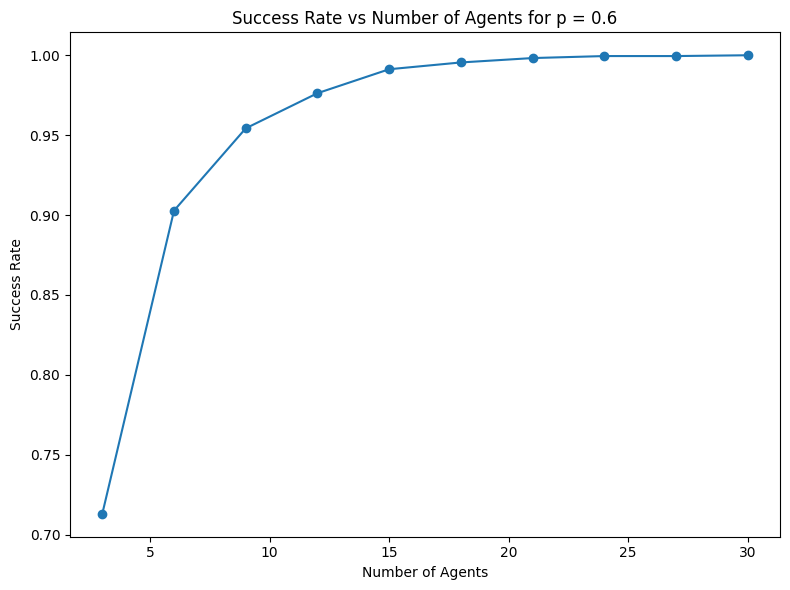

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

iterations_per_agent = 4000
competence = 0.6
agent_counts = [3,6,9,12,15,18,21,24,27,30]  # Number of agents from 2 to 10

# Array with values showing success rate corresponding to number of agents
success_rates = []

for agents in agent_counts:
    single_round_successes = []
    ties = 0


    j = 0
    # Run specified number of times
    while j < iterations_per_agent:

        deliberation_setting = DeliberationSetting(p_competence = 0.6, a_evidence=6, b_evidence=5, no_of_agents=agents)
        result = deliberation_setting.run_sim_keen()

        if result is not None:
            single_round_successes.append(result)
            j += 1
        else:
            single_round_successes.append(result)
            j +=1

    # Calculate relative success
    success_rate = single_round_successes.count('A') / iterations_per_agent
    success_rates.append(success_rate)

# Generate the new plot with number of agents vs success rate
plt.figure(figsize=(8, 6))

plt.title("Success Rate vs Number of Agents for p = 0.6")
plt.xlabel("Number of Agents")
plt.ylabel("Success Rate")
plt.plot(agent_counts, success_rates, marker='o')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

# Sample data for success rates
agent_counts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
p_competence = 0.6

def condorcet(n, p):
    sum_result = 0
    for i in range((n // 2) + 1, n + 1):
        binom_coeff = scipy.special.comb(n, i)
        term = binom_coeff * (p ** i) * ((1 - p) ** (n - i))
        sum_result += term
    return sum_result

# Compute Condorcet values for the given range of agent counts
condorcet_values = [condorcet(n, p_competence) for n in agent_counts]

# Diagnostic print to understand the behavior of condorcet values
for n, value in zip(agent_counts, condorcet_values):
    print(f'Agents: {n}, Condorcet Value: {value}')

# Plot success rates and Condorcet values
plt.figure(figsize=(10, 6))

plt.plot(agent_counts, success_rates, marker='o', label='Success Rates')
plt.plot(agent_counts, condorcet_values, marker='x', label='Condorcet Values')

plt.title("Success Rates and Condorcet Values vs Number of Agents")
plt.xlabel("Number of Agents")
plt.ylabel("Success Rate / Condorcet Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Agents: 3, Condorcet Value: 0.648
Agents: 6, Condorcet Value: 0.54432
Agents: 9, Condorcet Value: 0.7334323199999999
Agents: 12, Condorcet Value: 0.6652085575679999
Agents: 15, Condorcet Value: 0.786896817389568
Agents: 18, Condorcet Value: 0.7368411690211737
Agents: 21, Condorcet Value: 0.8256221336382271
Agents: 24, Condorcet Value: 0.7869782010394586
Agents: 27, Condorcet Value: 0.85534823563728
Agents: 30, Condorcet Value: 0.8246309464931707


NameError: name 'success_rates' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:


def diversity(es_1, es_2):

    if len(es_1) != len(es_2):
        return ValueError('Evidence sets not of the same length')

    difference = 0

    for i in range(len(es_1)):
        if es_1[i] != es_2[i]:
            difference += 1

    es_1_evidence = es_1.count(1)
    es_2_evidence = es_2.count(1)

    result = difference - abs(es_1_evidence-es_2_evidence)**2

    return result


def crowd_diversity(crowd: Crowd):
    diversity_cum = 0
    num_agents = len(crowd.agents)

    for i in range(num_agents):
        for j in range(i + 1, num_agents):
            agent1 = crowd.agents[i]
            agent2 = crowd.agents[j]
            diversity_cum += diversity(agent1.es_A, agent2.es_A)
            diversity_cum += diversity(agent1.es_B, agent2.es_B)

    return diversity_cum

def diverse_deliberation(mindiversity = 0, maxdiversity = 0):
    crowdsetting = DeliberationSetting()
    while crowd_diversity(crowdsetting.crowd) < mindiversity or crowd_diversity(crowdsetting.crowd) > maxdiversity:
        crowdsetting = DeliberationSetting()

    print('DIVERSITY SCORE OF THIS CROWD: ', crowd_diversity(crowdsetting.crowd))
    crowdsetting.run_sim_keen()

diverse_deliberation(mindiversity = 10, maxdiversity = 30)



DIVERSITY SCORE OF THIS CROWD:  16
['X', 'A', 'X', 'X', 'A']
First dissenters: ['B', None, 'B', 'B', None]
First majority vote: A

Agent 0 s dissenter_evidence for the minority B:  [1, 1]
Revealing new evidence 0 for minority option B from agent 0
Revealing new evidence 1 for minority option B from agent 0
Agent 2 s dissenter_evidence for the minority B:  [0, 1]
Agent 3 s dissenter_evidence for the minority B:  [0, 1]
New profile:  ['X', 'X', 'B', 'B', 'X']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  ['A', 'A', None, None, 'A']
Agent 0 s dissenter_evidence for the minority A:  [1, 1, 0]
Revealing new evidence 0 for minority option A from agent 0
Revealing new evidence 1 for minority option A from agent 0
Agent 1 s dissenter_evidence for the minority A:  [1, 1, 0]
Agent 4 s dissenter_evidence for the minority A:  [1, 0, 1]
Revealing new evidence 2 for minority option A from agent 4
New profile:  ['A', 'A', 'A', 'A', 'A']
Newly assigned majority:  A
Newly assgine

## Low p-competence sampling and simulation

In [ ]:
# prompt: Sample four buckets of crowds with an agents p-value 0.1, 0.2, 0.3, 0.4

# Create four buckets of crowds with agents having p-values 0.1, 0.2, 0.3, and 0.4
crowd_buckets = []
result_buckets = []
p_values = [0.1, 0.2, 0.3, 0.4]

for p_value in p_values:
    crowd_bucket = []
    result_bucket = []
    for _ in range(4000):
        deliberation_setting = DeliberationSetting(p_competence=p_value)
        deliberation_result = deliberation_setting.run_sim_keen()
        crowd_bucket.append(deliberation_setting.crowd)
        result_bucket.append(deliberation_result)

    crowd_buckets.append(crowd_bucket)
    result_buckets.append(result_bucket)

# Print the number of crowds in each bucket
for i, bucket in enumerate(result_buckets):
    print(f"Bucket {i+1} (p-value = {p_values[i]}): {len(bucket)} crowds")


Streaming output truncated to the last 5000 lines.
Revealing new evidence 1 for minority option B from agent 0
Agent 2 s dissenter_evidence for the minority B:  [1, 0]
Revealing new evidence 0 for minority option B from agent 2
New profile:  ['B', 'B', 'B', 'X', 'X']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  [None, None, None, 'A', 'A']
Agent 3 s dissenter_evidence for the minority A:  [1, 1, 0]
Revealing new evidence 0 for minority option A from agent 3
Revealing new evidence 1 for minority option A from agent 3
Agent 4 s dissenter_evidence for the minority A:  [1, 1, 0]
New profile:  ['X', 'X', 'X', 'X', 'X']
Tie! Adjust number of agents using set_no_of_agents.
Newly assigned majority:  X
Newly assgined minority:  B
Tie! Adjust number of agents using set_no_of_agents.
Dissenters:  [None, None, None, None, None]
Generating plot for deliberation end result...
1
Evidence A: █▒
Evidence B: █▒
2
Evidence A: █▒
Evidence B: ▒▒
3
Evidence A: █▒
Evidence B: █▒
4
Evi

In [ ]:
random_p_results = []
for _ in range(4000):
    deliberation_setting = DeliberationSetting(p_competence=p_value)
    deliberation_result = deliberation_setting.run_sim_keen()
    random_p_results.append(deliberation_result)

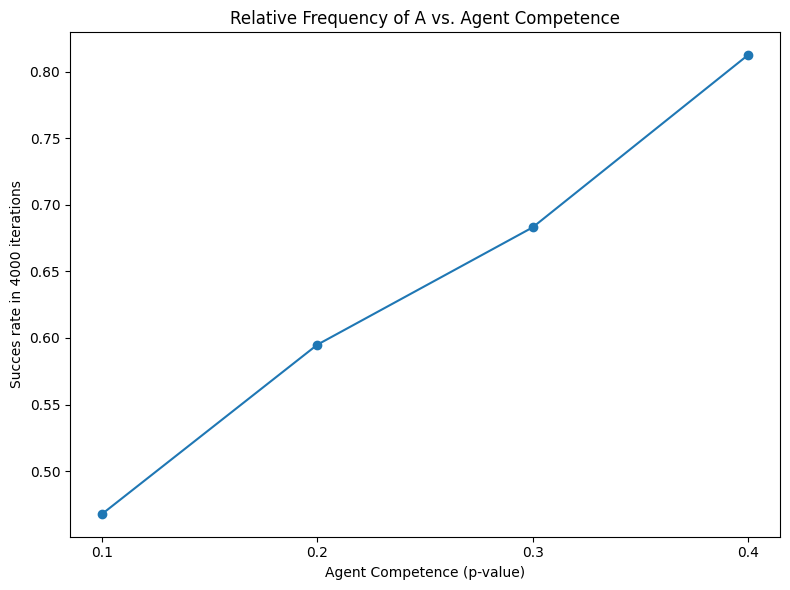

In [ ]:
# Plot the relative frequencies of A in the results buckets with the x axis displaying the agents competence

# Extract the relative frequencies of A from each result bucket
relative_frequencies = []
for bucket in result_buckets:
    success_count = bucket.count('A')
    relative_frequency = success_count / len(bucket)
    relative_frequencies.append(relative_frequency)

# Plot the relative frequencies against the agents' competence levels
plt.figure(figsize=(8, 6))
plt.title("Relative Frequency of A vs. Agent Competence")
plt.xlabel("Agent Competence (p-value)")
plt.ylabel("Succes rate in 4000 iterations")
plt.plot(p_values, relative_frequencies, marker='o')
plt.xticks(p_values)
plt.tight_layout()
plt.show()


## Low individual competence sampling and simulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import sympy as sp


def prob_correct(a, b, p):
    summation = 0
    for b_i in range(b + 1):
        inner_sum = 0
        for k in range(1, a - b_i + 1):
            term = (sp.binomial(a, b_i + k) * sp.binomial(b, b_i) *
                    p**(2*b_i + k) * (1 - p)**(a + b - (2*b_i + k)))
            inner_sum += term
        summation += inner_sum
    return summation

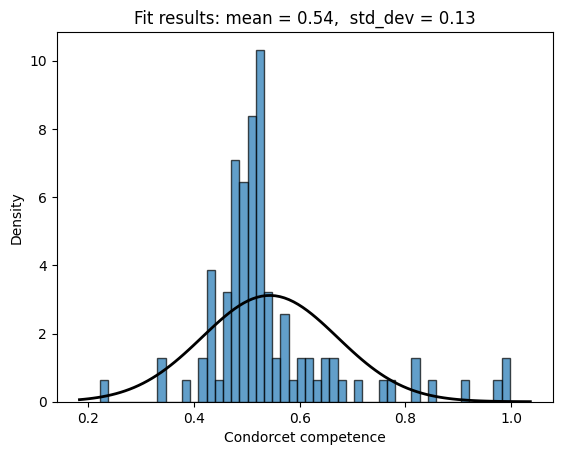

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming Crowd and prob_correct are defined elsewhere

diversity_scores_uniform = []
for _ in range(100):
    random_b = random.randrange(1, 200)
    random_k = random.randrange(1, 4)
    random_a = random_b + random_k
    random_p= random.uniform(0, 1)
    crowd = Crowd(no_of_agents=5, a_evidence=random_a, b_evidence=random_b, p_competence=random_p)
    score = prob_correct(random_a, random_b, random_p)
    diversity_scores_uniform.append(score)

# Check for NaN or infinite values
diversity_scores_uniform = np.array(diversity_scores_uniform, dtype=np.float64)
if np.any(np.isnan(diversity_scores_uniform)) or np.any(np.isinf(diversity_scores_uniform)):
    print("Error: The list contains NaN or infinite values.")
else:
    # Plot the histogram of diversity scores
    plt.hist(diversity_scores_uniform, bins=50, edgecolor='black', alpha=0.7, density=True)

    # Fit a normal distribution to the data
    mean, std_dev = np.mean(diversity_scores_uniform), np.std(diversity_scores_uniform)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std_dev)

    # Plot the normal distribution curve
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mean = %.2f,  std_dev = %.2f" % (mean, std_dev)
    plt.title(title)

    plt.xlabel('Condorcet competence')
    plt.ylabel('Density')
    plt.show()


In [ ]:
# Create four buckets of crowds with agents having p-values 0.1, 0.2, 0.3, and 0.4
import random
import numpy as np
number_of_agents = [3,4,5,6,7,8,9,10]
buckets_1 = []
buckets_2 = []
buckets_3 = []
buckets_4 = []
buckets_5 = []
buckets_6 = []

# Generate crowds and place them in buckets
for no_of_agents in number_of_agents:
  bucket_1 = []
  bucket_2 = []
  bucket_3 = []
  bucket_4 = []
  bucket_5 = []
  bucket_6 = []
  while len(bucket_1) < 100 or len(bucket_2) < 100 or len(bucket_3) < 100 or len(bucket_4)<100 or len(bucket_5) < 100:
      random_b = random.randrange(1,100)
      random_k = random.randrange(1,4)
      random_a = random_b + random_k
      crowd = Crowd(no_of_agents=no_of_agents, a_evidence=random_a, b_evidence=random_b)
      score = prob_correct(random_a, random_b, random.uniform(0, 1))

      if score <= 0.2 and len(bucket_1) < 100:
          bucket_1.append(crowd)
          print('Bucket 1: ', len(bucket_1))
      elif 0.2 < score <= 0.3 and len(bucket_2) < 100:
          bucket_2.append(crowd)
          print('Bucket 2: ', len(bucket_2))
      elif 0.3 < score <= 0.4 and len(bucket_3) < 100:
          bucket_3.append(crowd)
          print('Bucket 3: ', len(bucket_3))
      elif 0.4 < score <= 0.5 and len(bucket_4) < 100:
          bucket_4.append(crowd)
          print('Bucket 4: ', len(bucket_4))
      elif 0.5 < score <= 0.6 and len(bucket_5) < 100:
          bucket_5.append(crowd)
          print('Bucket 5: ', len(bucket_5))
      elif 0.6 < score <= 0.7 and len(bucket_6) < 100:
          bucket_6.append(crowd)
          print('Bucket 6: ', len(bucket_6))
      else:
          pass

  # Verify the number of crowds in each bucket
  len(bucket_1), len(bucket_2), len(bucket_3), len(bucket_4), len(bucket_5), len(bucket_6)
  buckets_1.append(bucket_1)
  buckets_2.append(bucket_2)
  buckets_3.append(bucket_3)
  buckets_4.append(bucket_4)
  buckets_5.append(bucket_5)
  buckets_6.append(bucket_6)




Bucket 5:  1
Bucket 5:  2
Bucket 5:  3
Bucket 5:  4
Bucket 5:  5
Bucket 6:  1
Bucket 5:  6
Bucket 5:  7
Bucket 5:  8
Bucket 5:  9
Bucket 5:  10
Bucket 5:  11
Bucket 5:  12
Bucket 5:  13
Bucket 5:  14
Bucket 5:  15
Bucket 1:  1
Bucket 4:  1
Bucket 5:  16
Bucket 4:  2
Bucket 5:  17
Bucket 4:  3
Bucket 6:  2
Bucket 4:  4
Bucket 6:  3
Bucket 5:  18
Bucket 4:  5
Bucket 6:  4
Bucket 4:  6
Bucket 4:  7
Bucket 5:  19
Bucket 4:  8
Bucket 5:  20
Bucket 5:  21
Bucket 4:  9
Bucket 6:  5
Bucket 5:  22
Bucket 5:  23
Bucket 4:  10
Bucket 5:  24
Bucket 6:  6
Bucket 3:  1
Bucket 1:  2
Bucket 4:  11
Bucket 5:  25
Bucket 5:  26
Bucket 4:  12
Bucket 5:  27
Bucket 5:  28
Bucket 5:  29
Bucket 6:  7
Bucket 5:  30
Bucket 5:  31
Bucket 5:  32
Bucket 4:  13
Bucket 4:  14
Bucket 4:  15
Bucket 5:  33
Bucket 5:  34
Bucket 6:  8
Bucket 5:  35
Bucket 6:  9
Bucket 3:  2
Bucket 3:  3
Bucket 5:  36
Bucket 5:  37
Bucket 4:  16
Bucket 5:  38
Bucket 6:  10
Bucket 5:  39
Bucket 5:  40
Bucket 6:  11
Bucket 5:  41
Bucket 4: 

KeyboardInterrupt: 

In [ ]:
# Create four buckets of crowds with agents having p-values 0.1, 0.2, 0.3, and 0.4
import random
import numpy as np
number_of_agents = [3,4,5,6,7,8,9,10]
buckets_1 = []
buckets_2 = []
buckets_3 = []
buckets_4 = []
buckets_5 = []
buckets_6 = []

# Generate crowds and place them in buckets
for no_of_agents in number_of_agents:
  bucket_1 = []
  bucket_2 = []
  bucket_3 = []
  bucket_4 = []
  bucket_5 = []
  bucket_6 = []
  while len(bucket_1) < 100 or len(bucket_2) < 100 or len(bucket_3) < 100 or len(bucket_4)<100 or len(bucket_5) < 100:
      random_b = random.randrange(1,5)
      random_k = random.randrange(1,4)
      random_a = random_b + random_k
      random_p = random.uniform(0, 1)
      crowd = Crowd(no_of_agents=no_of_agents, a_evidence=random_a, b_evidence=random_b, p_competence=random_p)
      score = prob_correct(random_a, random_b, random.uniform(0, 1))

      if score <= 0.2 and len(bucket_1) < 100:
          bucket_1.append(crowd)
          print('Bucket 1: ', len(bucket_1))
      elif 0.2 < score <= 0.3 and len(bucket_2) < 100:
          bucket_2.append(crowd)
          print('Bucket 2: ', len(bucket_2))
      elif 0.3 < score <= 0.4 and len(bucket_3) < 100:
          bucket_3.append(crowd)
          print('Bucket 3: ', len(bucket_3))
      elif 0.4 < score <= 0.5 and len(bucket_4) < 100:
          bucket_4.append(crowd)
          print('Bucket 4: ', len(bucket_4))
      elif 0.5 < score <= 0.6 and len(bucket_5) < 100:
          bucket_5.append(crowd)
          print('Bucket 5: ', len(bucket_5))
      elif 0.6 < score <= 0.7 and len(bucket_6) < 100:
          bucket_6.append(crowd)
          print('Bucket 6: ', len(bucket_6))
      else:
          pass

  # Verify the number of crowds in each bucket
  len(bucket_1), len(bucket_2), len(bucket_3), len(bucket_4), len(bucket_5), len(bucket_6)
  buckets_1.append(bucket_1)
  buckets_2.append(bucket_2)
  buckets_3.append(bucket_3)
  buckets_4.append(bucket_4)
  buckets_5.append(bucket_5)
  buckets_6.append(bucket_6)

Bucket 5:  1
Bucket 4:  1
Bucket 6:  1
Bucket 3:  1
Bucket 2:  1
Bucket 3:  2
Bucket 3:  3
Bucket 3:  4
Bucket 5:  2
Bucket 6:  2
Bucket 2:  2
Bucket 4:  2
Bucket 4:  3
Bucket 3:  5
Bucket 4:  4
Bucket 5:  3
Bucket 1:  1
Bucket 3:  6
Bucket 5:  4
Bucket 6:  3
Bucket 4:  5
Bucket 5:  5
Bucket 5:  6
Bucket 4:  6
Bucket 4:  7
Bucket 6:  4
Bucket 4:  8
Bucket 5:  7
Bucket 1:  2
Bucket 3:  7
Bucket 5:  8
Bucket 3:  8
Bucket 3:  9
Bucket 5:  9
Bucket 5:  10
Bucket 6:  5
Bucket 6:  6
Bucket 6:  7
Bucket 4:  9
Bucket 6:  8
Bucket 4:  10
Bucket 5:  11
Bucket 3:  10
Bucket 4:  11
Bucket 3:  11
Bucket 1:  3
Bucket 3:  12
Bucket 2:  3
Bucket 2:  4
Bucket 5:  12
Bucket 4:  12
Bucket 5:  13
Bucket 4:  13
Bucket 1:  4
Bucket 6:  9
Bucket 5:  14
Bucket 6:  10
Bucket 6:  11
Bucket 4:  14
Bucket 5:  15
Bucket 3:  13
Bucket 5:  16
Bucket 6:  12
Bucket 5:  17
Bucket 2:  5
Bucket 4:  15
Bucket 5:  18
Bucket 4:  16
Bucket 6:  13
Bucket 4:  17
Bucket 5:  19
Bucket 5:  20
Bucket 4:  18
Bucket 3:  14
Bucket 2:

Streaming output truncated to the last 5000 lines.
Evidence A: ▒▒▒▒
Evidence B: ██
6
Evidence A: ▒▒▒▒
Evidence B: █
7
Evidence A: ▒▒▒▒
Evidence B: 
8
Evidence A: ▒▒▒▒
Evidence B: 
9
Evidence A: █▒▒▒
Evidence B: 
10
Evidence A: █▒▒▒
Evidence B: █
_______________WINNER A.______________
Termination at round 1: No more dissenters.
['A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A']
First dissenters: [None, None, None, None, None, None, 'B', None, None, None]
First majority vote: A

Agent 6 s dissenter_evidence for the minority B:  [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]
Revealing new evidence 0 for minority option B from agent 6
Revealing new evidence 2 for minority option B from agent 6
Revealing new evidence 3 for minority option B from agent 6

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

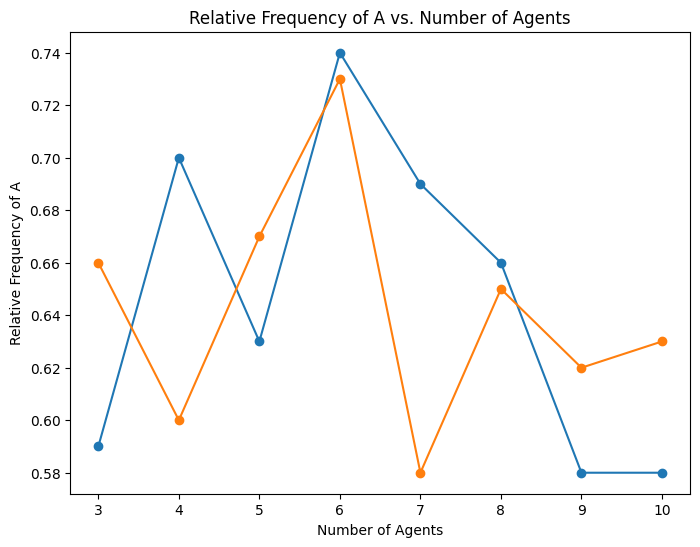

In [ ]:
# prompt: For each crowd in each bucket, let them deliberate, and calculate the relative success rates of the crowds in each bucket. Plot the results from the two buckets as two seperate lines on a graph with the x axis as the number of agents

# Initialize result buckets for each bucket
result_buckets_1 = []
result_buckets_2 = []
result_buckets_3 = []
result_buckets_4 = []
result_buckets_5 = []
result_buckets_6 = []

# Iterate through each bucket and simulate deliberations
for bucket in buckets_1:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_1.append(bucket_results)

for bucket in buckets_2:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_2.append(bucket_results)

for bucket in buckets_3:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()

for bucket in buckets_4:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()

for bucket in buckets_5:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()

for bucket in buckets_6:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()

# Calculate relative success rates for each bucket
relative_frequencies_1 = []
relative_frequencies_2 = []
relative_frequencies_3 = []
relative_frequencies_4 = []
relative_frequencies_5 = []
relative_frequencies_6 = []

for bucket_results in result_buckets_1:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_1.append(relative_frequency)

for bucket_results in result_buckets_2:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_2.append(relative_frequency)

for bucket_results in result_buckets_3:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_3.append(relative_frequency)

for bucket_results in result_buckets_4:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_4.append(relative_frequency)

for bucket_results in result_buckets_5:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_5.append(relative_frequency)

for bucket_results in result_buckets_6:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_6.append(relative_frequency)

# Plot the relative frequencies for each bucket
plt.figure(figsize=(8, 6))
plt.title("Relative Frequency of A vs. Number of Agents")
plt.xlabel("Number of Agents")
plt.ylabel("Relative Frequency of A")
plt.plot(number_of_agents, relative_frequencies_1, marker='o', label="Bucket 1 (p <= 0.2)")
plt.plot(number_of_agents, relative_frequencies_2, marker='o', label="Bucket 2 (0.2 < p <= 0.3)")
plt.plot(number_of_agents, relative_frequencies_3, marker='o', label="Bucket 3 (0.3 < p <= 0.4)")
plt.plot(number_of_agents, relative_frequencies_4, marker='o', label="Bucket 4 (0.4 < p <= 0.5)")
plt.plot(number_of_agents, relative_frequencies_5, marker='o', label="Bucket 5 (0.5 < p <= 0.6)")
plt.plot(number_of_agents, relative_frequencies_6, marker='o', label="Bucket 6 (0.6 < p <= 0.7)")
plt.xticks(number_of_agents)
plt.legend()
plt.tight_layout()
plt.show()


Streaming output truncated to the last 5000 lines.
Agent 3 s dissenter_evidence for the minority B:  [0, 0]
Agent 4 s dissenter_evidence for the minority B:  [0, 0]
Agent 9 s dissenter_evidence for the minority B:  [0, 1]
New profile:  ['A', 'A', 'B', 'B', 'B', 'B', 'B', 'X', 'B', 'B']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  ['A', 'A', None, None, None, None, None, 'A', None, None]
Agent 0 s dissenter_evidence for the minority A:  [1, 1, 1, 0, 0]
Revealing new evidence 0 for minority option A from agent 0
Revealing new evidence 1 for minority option A from agent 0
Revealing new evidence 2 for minority option A from agent 0
Agent 1 s dissenter_evidence for the minority A:  [1, 0, 1, 1, 0]
Revealing new evidence 3 for minority option A from agent 1
Agent 7 s dissenter_evidence for the minority A:  [0, 1, 0, 0, 1]
Revealing new evidence 4 for minority option A from agent 7
New profile:  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
Newly assigned majority

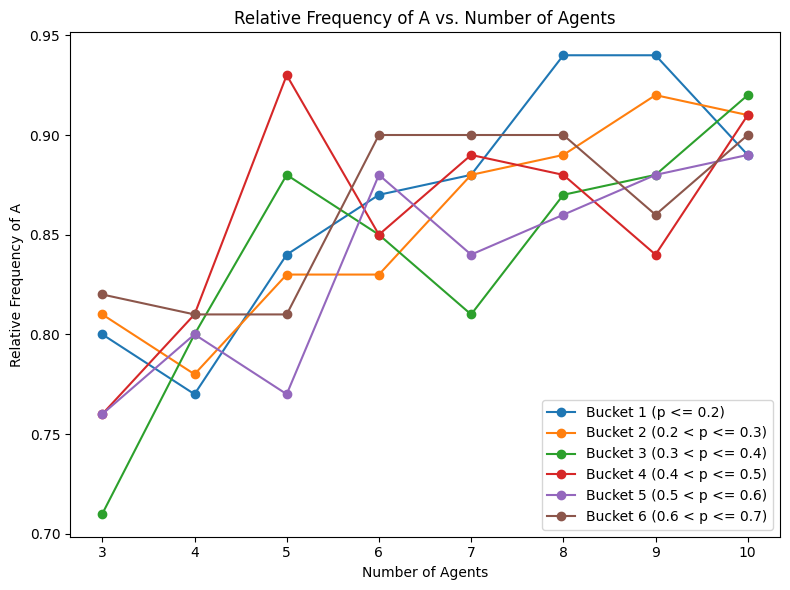

In [ ]:
import matplotlib.pyplot as plt

# Initialize result buckets for each bucket
result_buckets_1 = []
result_buckets_2 = []
result_buckets_3 = []
result_buckets_4 = []
result_buckets_5 = []
result_buckets_6 = []

# Iterate through each bucket and simulate deliberations
for bucket in buckets_1:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_1.append(bucket_results)

for bucket in buckets_2:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_2.append(bucket_results)

for bucket in buckets_3:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_3.append(bucket_results)

for bucket in buckets_4:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_4.append(bucket_results)

for bucket in buckets_5:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_5.append(bucket_results)

for bucket in buckets_6:
    bucket_results = []
    for crowd in bucket:
        deliberation_result = crowd.deliberate_sim()
        bucket_results.append(deliberation_result)
    result_buckets_6.append(bucket_results)

# Calculate relative success rates for each bucket
relative_frequencies_1 = []
relative_frequencies_2 = []
relative_frequencies_3 = []
relative_frequencies_4 = []
relative_frequencies_5 = []
relative_frequencies_6 = []

for bucket_results in result_buckets_1:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_1.append(relative_frequency)

for bucket_results in result_buckets_2:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_2.append(relative_frequency)

for bucket_results in result_buckets_3:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_3.append(relative_frequency)

for bucket_results in result_buckets_4:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_4.append(relative_frequency)

for bucket_results in result_buckets_5:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_5.append(relative_frequency)

for bucket_results in result_buckets_6:
    success_count = bucket_results.count('A')
    relative_frequency = success_count / len(bucket_results)
    relative_frequencies_6.append(relative_frequency)

# Plot the relative frequencies for each bucket
plt.figure(figsize=(8, 6))
plt.title("Relative Frequency of A vs. Number of Agents")
plt.xlabel("Number of Agents")
plt.ylabel("Relative Frequency of A")
plt.plot(number_of_agents, relative_frequencies_1, marker='o', label="Bucket 1 (p <= 0.2)")
plt.plot(number_of_agents, relative_frequencies_2, marker='o', label="Bucket 2 (0.2 < p <= 0.3)")
plt.plot(number_of_agents, relative_frequencies_3, marker='o', label="Bucket 3 (0.3 < p <= 0.4)")
plt.plot(number_of_agents, relative_frequencies_4, marker='o', label="Bucket 4 (0.4 < p <= 0.5)")
plt.plot(number_of_agents, relative_frequencies_5, marker='o', label="Bucket 5 (0.5 < p <= 0.6)")
plt.plot(number_of_agents, relative_frequencies_6, marker='o', label="Bucket 6 (0.6 < p <= 0.7)")
plt.xticks(number_of_agents)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def condorcet(n, p):
    sum_result = 0
    for i in range((n // 2) + 1, n + 1):
        binom_coeff = scipy.special.comb(n, i)
        term = binom_coeff * (p ** i) * ((1 - p) ** (n - i))
        sum_result += term
    return sum_result


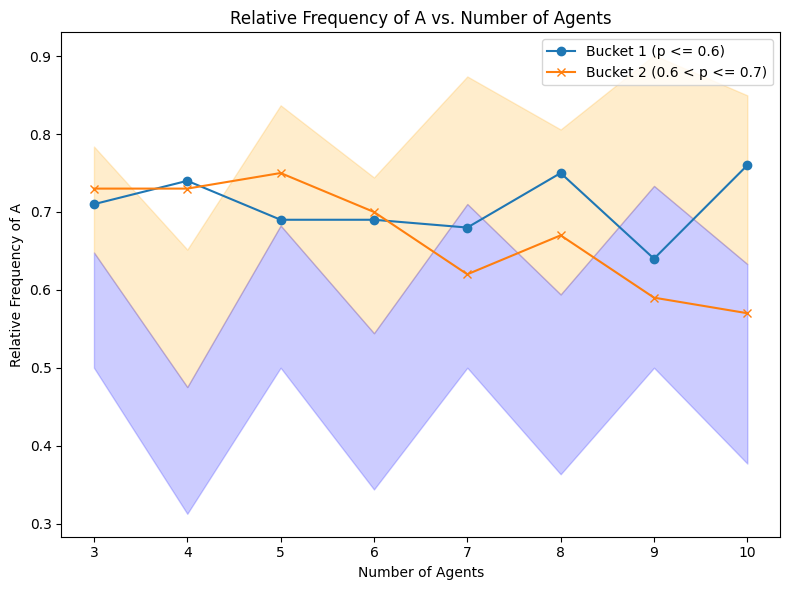

In [ ]:
# Plot the relative frequencies for each bucket

plt.figure(figsize=(8, 6))
plt.title("Relative Frequency of A vs. Number of Agents")
plt.xlabel("Number of Agents")
plt.ylabel("Relative Frequency of A")

# Calculate condorcet values for different probabilities
condorcet_06 = [condorcet(n, 0.6) for n in number_of_agents]
condorcet_05 = [condorcet(n, 0.5) for n in number_of_agents]
condorcet_07 = [condorcet(n, 0.7) for n in number_of_agents]


# Fill the region between y1 and y2
plt.fill_between(number_of_agents, condorcet_06, condorcet_07, color='orange', alpha=0.2)
plt.fill_between(number_of_agents, condorcet_05, condorcet_06, color='blue', alpha=0.2)


# Plot the data points
plt.plot(number_of_agents, relative_frequencies_1, marker='o', label="Bucket 1 (p <= 0.6)")
plt.plot(number_of_agents, relative_frequencies_2, marker='x', label="Bucket 2 (0.6 < p <= 0.7)")
plt.xticks(number_of_agents)
plt.legend()
plt.tight_layout()
plt.show()



Scatter plot (maybe?)
